In [2]:
import cv2
import numpy as np
import time
import datetime
from matplotlib import pyplot as plt
from cartpole_lib_python import *

In [3]:
init_odrive()
init_odrive()

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
odrive initialized
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
odrive initialized


In [4]:
def busy_sleep(duration, loop_start, get_now=time.perf_counter):
    now = get_now()

    end = duration + loop_start

    while now < end:
        now = get_now()

In [223]:
print(get_state())

[-0.00041322314049586776, 1.5753982691585535, 3.449298490732476e-16, 1.4159599180782914e-06]


1.5769322499464393

In [234]:
control_frequency = 30
control_period = 1/control_frequency
T = 600 # seconds
N = int(T*control_frequency)

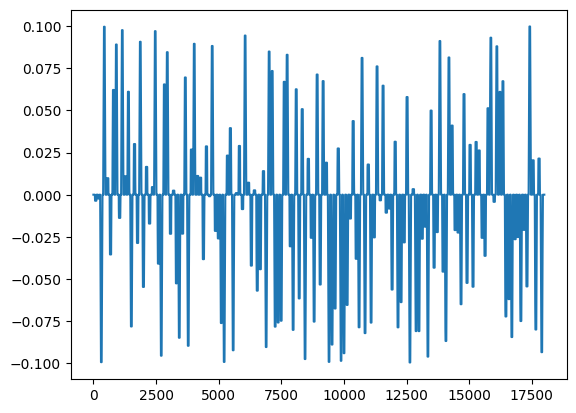

In [235]:

# go to random positions
num_points = int((N/30)/4)
goal_points_rand = np.random.uniform(low = -0.1, high = 0.1, size = num_points)
goal_points = [0]*(num_points*2+1)
goal_points[1::2] = goal_points_rand
x_ref = [0]*N
division_len = N/len(goal_points)
division_num = 0
ramp_mult = 300
for i in range(len(x_ref)):
    if i > division_len*(division_num+1):
        division_num += 1
    
    if division_num < len(goal_points)-1:
        ramp_len = int(abs(goal_points[division_num+1] - goal_points[division_num])*ramp_mult)
        start_ramp_pos = division_len*(division_num+1) - ramp_len
        end_ramp_pos = division_len*(division_num+1)
        if i > start_ramp_pos and i <= end_ramp_pos and division_num < len(goal_points)-1:
            m = (goal_points[division_num+1] - goal_points[division_num])/(end_ramp_pos - start_ramp_pos)
            b = goal_points[division_num+1] - m*end_ramp_pos
            x_ref[i] = m*i + b
        else:
            x_ref[i] = goal_points[division_num]
    else:
        x_ref[i] = goal_points[division_num]

plt.plot(x_ref)

In [230]:
vid = cv2.VideoCapture(1, cv2.CAP_DSHOW)
# vid = cv2.VideoCapture(1)
# vid.set(cv2.CAP_PROP_FPS, 60)
vid.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

for i in range(60): # 2 seconds of camera footage
    ret, frame = vid.read()
    if ret:
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh_image = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)
    else:
        print("no ret")


measurements = np.zeros((N,2)) # initialize data array
states_actual = np.zeros((N,4)) # initialize data array
states = np.zeros((N,4)) # initialize data array
predicted_states = np.zeros((N,4)) # initialize data array
controls_actual = np.zeros((N,1)).astype(float) # initialize control array
controls_filtered = np.zeros((N,1)).astype(float)

camera_time = []
kf_time = []
loop_time = []
frames = []

control_clamp = 0.2

xg = np.array([0.0, 1.5769322499464393, 0.0, 0.0]) # x, θ, xv, θv (use print(get_state())) to find these

# sinusoid trajectory to track with cart position (x)
# x_ref = [np.sin(t/10)*.12 for t in range(N)]

# square wave trajectory
# length = 300
# x_ref = [.02 if (i%length)/length < .5 else -.09 for i in range(N)]


k_matrix = np.array([-4.68901, -27.56145, -4.56255, -5.56030]) # 30hz

# 30 hz
A = np.array([ [1.0,  -0.00263967,  0.0333333,  -2.92458e-5],
               [0.0,   1.01727,     0.0,         0.0335247],
               [0.0,  -0.158834,    1.0,        -0.00263967],
               [0.0,   1.03916,     0.0,         1.01727] ])

B = np.array([ [ 0.001166386647061344],
               [-0.0024900041079065627],
               [ 0.07004855111703442],
               [-0.1498278085801933] ])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

meas_noise_cov = np.diag([.1,.1]) # most recent
process_noise_cov = np.diag([1,1,50,50]) # position, angle, linear velocity, angular velocity

nx = process_noise_cov.shape[0]
def kf_update(x_meas, x_pred_prev, est_cov_prev):
    Kn = est_cov_prev@H.T @ np.linalg.inv(H@est_cov_prev@H.T + meas_noise_cov)
    x = x_pred_prev + Kn @ (x_meas - H@x_pred_prev)
    est_cov = (np.eye(nx) - Kn@H) @ est_cov_prev @ (np.eye(nx) - Kn@H).T + Kn@meas_noise_cov@Kn.T
    return x, est_cov

def kf_predict(state, control, est_cov):
    x_pred = A@state + B@control
    est_cov_pred = A@est_cov@A.T + process_noise_cov
    return x_pred, est_cov_pred


learned_KF_matrices = np.load("data/learned_KF_matrices_3.npy")
LC = learned_KF_matrices["LC"]
L = -learned_KF_matrices["L"]
learned_bias = learned_KF_matrices["d2"]

def kf_pixel_update(ykp1, xkp1_pred):
    # Update
    xkp1_corrected = (np.eye(len(LC))-LC)@xkp1_pred + ((L@ykp1).T)[0] + learned_bias

    return xkp1_corrected

def kf_pixel_predict(xk_corrected, uk):
    # Predict
    # delta_xkp1_pred = A@(xk_corrected-x_eq) + B@(uk-u_eq)
    delta_xkp1_pred = A@xk_corrected + B@uk
    
    return delta_xkp1_pred


meas = get_measurement() - xg[:2]
x = np.array([meas[0], meas[1], 0, 0])
x_pred_prev = x


# Estimation covariance
est_cov = np.eye(nx)*20
est_cov_prev = est_cov

est_covs = np.zeros((N,nx,nx)).astype(float)
est_covs[0] = est_cov


print("start")
start = time.time()
for i in range(N):
    time_start = time.perf_counter()
    # xg[0] = midpoint + x_ref[i]
    # xg[0] = x_ref[i]
    
    # 1. Get image
    ret, frame = vid.read()
    if ret:
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh_image = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)
        blur_image = cv2.blur(thresh_image, (10, 10)).astype(float)/255
        frames.append(blur_image)
    else:
        print("no ret")
    
    camera_time.append(time.perf_counter() - time_start)
    
    # 2. Get state estimate from KF ([x,θ,xv,θv] from image)
    
    
    # Measure encoders
    measurement = get_measurement() - xg[:2]
    measurements[i,:] = measurement
    
    if i > 0:
        # KF update step using encoder measurements
        # x, est_cov = kf_update(measurement, x_pred_prev, est_cov_prev)
        x = kf_pixel_update(thresh_image.T.reshape(-1,1), x_pred_prev)
        # print(x)
        est_covs[i] = est_cov
        
    predicted_states[i,:] = x_pred_prev
    states_actual[i,:] = x # Change this to output of image KF when using PixelMPC

    # predicted_states[i,:] = [0,0,0,0]
    # states_actual[i,:] = [0,0,0,0]
    
    # 3. Do control

    # Compute ground truth control values from undamped estimate    
    control_actual = -k_matrix @ states_actual[i,:].T
    controls_actual[i] = control_actual
    # controls_actual[i] = 0
    
    # Compute damped control value to send to cartpole
    x[3] /= 2
    states[i,:] = x
    control = -k_matrix @ states[i,:].T * 0.21 # Arbitrary multiplier to damp odrive torque output

    # control = states[i,1]/2
    if control > control_clamp:
        control = control_clamp
    elif control < -control_clamp:
        control = -control_clamp
    
    controls_filtered[i] = control
    # controls_filtered[i] = 0
    # KF predict step using encoder measurements
    # x_pred_prev, est_cov_prev = kf_predict(x, [control], est_cov)
    x_pred_prev = kf_pixel_predict(x, [control])

    control = 0
    command_linear_torque(-control) # Odrive torque direction is reversed from our 
        
        
    kf_time.append(time.perf_counter() - time_start)
    busy_sleep(control_period, time_start, get_now=time.perf_counter)
    loop_time.append(time.perf_counter() - time_start)

command_linear_torque(0)

print("took {} seconds".format(time.time() - start))

# Release the cap object after the loop 
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()


start
took 10.023242712020874 seconds


In [266]:
command_linear_torque(0)

In [116]:
# Save data to npz file
now = datetime.datetime.now()
file_name = "data/cartpole_train_data_" + now.strftime("%m-%d-%Y_%H-%M-%S") + ".npz"
np.savez(file_name, measurements=measurements, est_states=states_actual, est_states_damped=states, est_states_predicted=predicted_states, frames=frames, LQR_control_output=controls_actual, filtered_controls=controls_filtered)

In [252]:
npyfile = np.load("data/learned_KF_matrices.npy")
print(npyfile["LC"].shape)
print(npyfile["L"].shape)

(4, 4)
(4, 76800)


In [157]:
vid = cv2.VideoCapture(1, cv2.CAP_DSHOW)
# vid = cv2.VideoCapture(1)
# vid.set(cv2.CAP_PROP_FPS, 30)
vid.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
ret, frame = vid.read()
if ret:
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)
    blur = cv2.blur(thresh, (10, 10)).astype(float)/255
    cv2.imshow('frame', blur)
    cv2.waitKey()
# After the loop release the cap object q
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [161]:
np.savez("data/equilibrium_frame_blur.npz", eq_frame=blur)

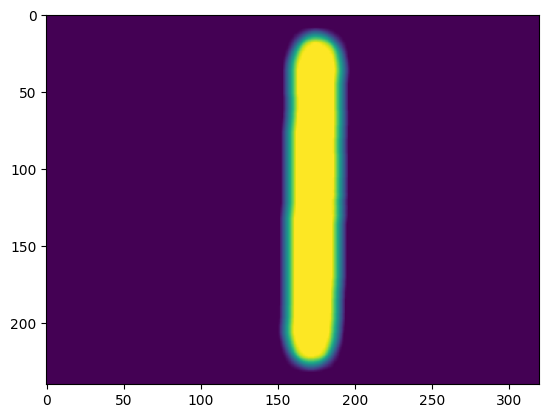

In [191]:
npzfile = np.load("data/equilibrium_frame_blur.npz")
plt.imshow(npzfile["eq_frame"])

In [231]:
control_period = 1/30

In [118]:
vid = cv2.VideoCapture(1, cv2.CAP_DSHOW)
# vid = cv2.VideoCapture(1)
# vid.set(cv2.CAP_PROP_FPS, 30)
vid.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
vid.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

while True:
    ret, frame = vid.read()
    if ret:
        gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY)
        blur = cv2.blur(thresh, (10, 10)).astype(float)/255
        blurdiff = blur - y_eq_mat
        cv2.imshow('frame', blur)
        # print(frame.shape)
    if cv2.waitKey(int(1000*control_period)) & 0xFF == ord('q'):
        break
print(np.sum(blur - y_eq_mat))
# After the loop release the cap object q
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

-6078.890196078431


In [229]:
print(len(frames))
for frame in frames:
    cv2.imshow('frame', frame)
    if cv2.waitKey(int(1000*control_period)) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

300


Text(0.5, 0, 'iteration')

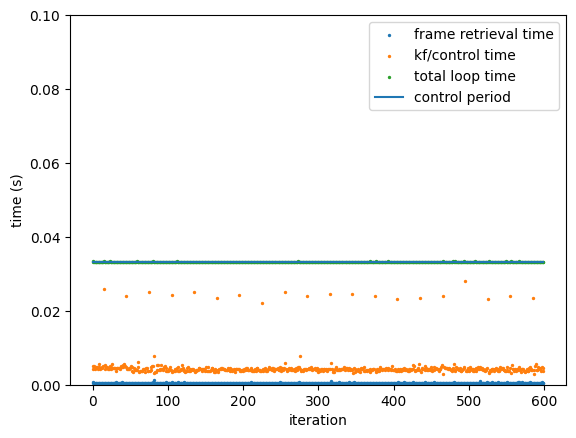

In [111]:
plt.scatter(range(len(loop_time)), np.array(camera_time), s=2)
plt.scatter(range(len(loop_time)), np.array(kf_time), s=2)
plt.scatter(range(len(loop_time)), np.array(loop_time), s=2)
plt.plot(np.array([control_period for _ in range(len(loop_time))]))
    
plt.ylim([0,.1])
plt.legend(["frame retrieval time", "kf/control time", "total loop time", "control period"])
plt.ylabel("time (s)")
plt.xlabel("iteration")

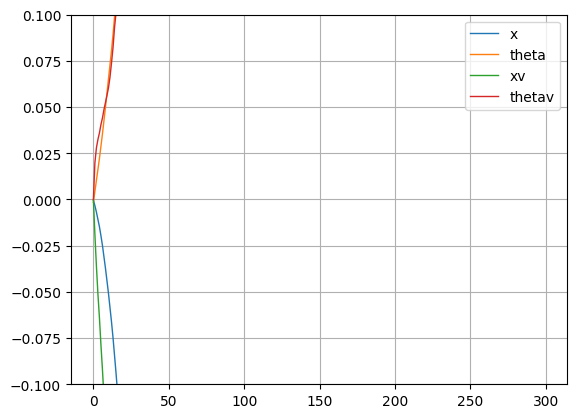

In [231]:
plt.plot(states, '-', linewidth=1)
plt.ylim([-.1,.1])
plt.legend(['x', 'theta', 'xv', 'thetav'])
plt.grid()
plt.show()

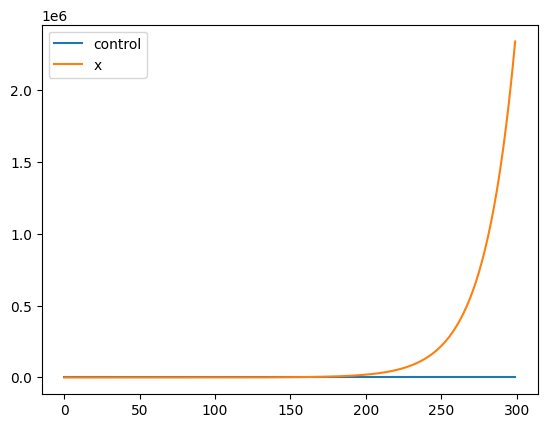

In [232]:
plt.plot(controls_filtered, label = "control")
plt.plot(controls_actual, label = "control")
# plt.plot(errs)
# plt.plot(np.vstack([states_lpf[:,0], states_lpf[:,2]]).T - np.tile(np.array([xg[0], xg[2]]),(len(states_lpf),1)))
# plt.plot(x_sin)
# plt.ylim([-control_clamp*1.1, control_clamp*1.1])
# plt.legend(["control", "pos err", "vel err", "traj_x", "traj_vel"])
plt.legend(["control", "x", "vel", "traj_x", "traj_vel"])